In [41]:
import torch
from torch import nn
import numpy as np
import random
from tqdm import tqdm

from itertools import product

import matplotlib.pyplot as plt

In [50]:
reduced_coefficients = np.load("./data/projected_matrix.npy")
snapshots = np.load("./data/snapshot_matrix.npy")
basis_matrix = np.load("./data/basis_matrix.npy")

In [25]:
# Seeds for reproducibility
# seed to split dataset into train/test
split_seed = 10
# seed for GFN-ROM initialisation
seed = 10

rate = 30

precision = torch.float64

In [26]:
# Mapper sizes
# Mapper maps from parameters to latent dimension
# We optionally allow the addition of further layers
mapper_sizes = [50, 50, 50, 50]

# Activation
act = nn.Tanh

# Number of epochs
epochs = 5000

# Learning rate
lr = 0.001

# L2 regularisation hyperparamter
lambda_ = 10**-5

In [27]:
mu_range = [(0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (-np.pi/6,np.pi/6), (-10,10)]
mus = []
n_pts = [2]*(len(mu_range)-1)+[11]
for i in range(len(mu_range)):
    mus.append(np.linspace(mu_range[i][0], mu_range[i][1], n_pts[i]))
params = torch.tensor(np.array(list(product(*mus))), dtype=precision)

In [28]:
np.random.seed(split_seed)

# Split parameter space for training and testing
num_graphs = params.shape[0]
total_sims = int(num_graphs)
rate = rate/100
train_sims = int(rate * total_sims)
test_sims = total_sims - train_sims
main_loop = np.arange(total_sims).tolist()
np.random.shuffle(main_loop)

train_trajs = main_loop[0:train_sims]
train_trajs.sort()
test_trajs = main_loop[train_sims:total_sims]
test_trajs.sort()

In [31]:
# Set seed
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_dtype(precision)

In [38]:
layers = [nn.Linear(params.shape[1], mapper_sizes[0]), act()]

for i in range(len(mapper_sizes)-1):
    layers.append(nn.Linear(mapper_sizes[i], mapper_sizes[i+1]))
    layers.append(act())
    
layers.append(nn.Linear(mapper_sizes[-1], reduced_coefficients.shape[1]))

model = nn.Sequential(*layers)

In [39]:
opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=lambda_)

100%|████████████████████████| 5000/5000 [00:59<00:00, 83.99it/s, Loss(training)=0.000105, Loss(testing)=tensor(0.0014)]


Text(0.5, 0, 'Epoch')

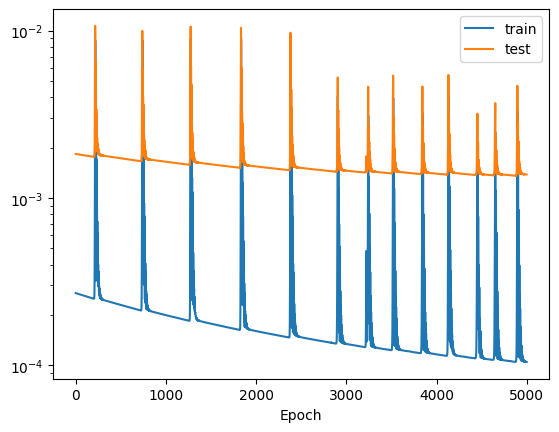

In [42]:
save_name = 'POD_NN'

true_reduced_coefficients = torch.tensor(reduced_coefficients)

best_loss = np.inf

loss_func = nn.MSELoss()

train_losses = []
test_losses = []

loop = tqdm(range(epochs))
for i in loop:
    opt.zero_grad()
    
    params_train = params[train_trajs]
    preds_train = model(params_train)
    true_train = true_reduced_coefficients[train_trajs]
    loss = loss_func(preds_train, true_train)
    loss.backward()
    opt.step()
    train_loss = loss.item()
    train_losses.append(train_loss)
    
    with torch.no_grad():
        params_test = params[test_trajs]
        preds_test = model(params_test)
        true_test = true_reduced_coefficients[test_trajs]
        test_loss = loss_func(preds_test, true_test)
        test_losses.append(test_loss)
    loop.set_postfix({"Loss(training)": train_loss, "Loss(testing)": test_loss})
            
    if test_loss<best_loss:
        best_loss = test_loss
        best_epoch = i
        torch.save(model.state_dict(), "models/"+save_name)
    
model.load_state_dict(torch.load("models/"+save_name))

# plot training losses
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.yscale('log')
plt.legend()
plt.xlabel('Epoch')
# plt.savefig('plots/loss_plot'+joined+run+'.png', bbox_inches='tight', dpi=500)

In [51]:
with torch.no_grad():
    predicted_coefficients = model(params)

predicted_snapshots = np.zeros(snapshots.shape)

for i in range(params.shape[0]):
    predicted_snapshots[i] = basis_matrix @ predicted_coefficients.numpy()[i]

In [57]:
def print_results(Z, Z_approx):
    Z = np.sqrt(np.sum(Z**2, axis=2)).T
    Z_approx = np.sqrt(np.sum(Z_approx**2, axis=2)).T
    
    error_abs_list = list()
    norm_z_list = list()

    for snap in range(Z.shape[1]):
        error_abs = np.linalg.norm(abs(Z[:, snap] - Z_approx[:, snap]))
        norm_z = np.linalg.norm(Z[:, snap], 2)
        error_abs_list.append(error_abs)
        norm_z_list.append(norm_z)

    error = np.array(error_abs_list)
    norm = np.array(norm_z_list)
    rel_error = error/norm
    print("\nMaximum absolute error for field "+" = ", max(error))
    print("Mean absolute error for field "+" = ", sum(error)/len(error))
    print("Minimum absolute error for field "+" = ", min(error))
    print("\nMaximum relative error for field "+" = ", max(rel_error))
    print("Mean relative error for field "+" = ", sum(rel_error)/len(rel_error))
    print("Minimum relative error for field "+" = ", min(rel_error))

In [58]:
print_results(predicted_snapshots, snapshots)


Maximum absolute error for field  =  6.659629973029338
Mean absolute error for field  =  1.0643992584844497
Minimum absolute error for field  =  0.19807911905107586

Maximum relative error for field  =  0.12141628943962553
Mean relative error for field  =  0.014165036076908388
Minimum relative error for field  =  0.0024327165647302375
